In [183]:
import requests 
from bs4 import BeautifulSoup as bs
import pandas as pd
import requests
import re

In [1]:
!pip install .

ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.


In [182]:
from elasticsearch import Elasticsearch, helpers
def greb_data_ES(index_name, size):
    es = Elasticsearch(
            "https://e32aaa94f81549368f75827f1e5da659.us-central1.gcp.cloud.es.io/",
            api_key=("g1i_hJIBR8AYR_FZHqsZ", "NgU5E6CkSJmd1t8uuljJJA"),
            timeout=60
            )
    print(es.info())
    response = es.search(
        index=index_name,
        body={
            "size": size,
            "_source": ["steamId", "tags", "genres", "features"],
            "query": {
                "match_all": {}
            }
        }
    )
    return response['hits']['hits']

In [9]:

def get_last_month_avg(game_id):
    # 目標 URL
    url = f"https://steamcharts.com/app/{game_id}"
    # 發送 GET 請求
    number_pattern = re.compile(r'\d+[\.,]?\d*')
    response = requests.get(url)
    print(response)
    if response.status_code == 200:
        # 解析 HTML
        soup = bs(response.text, 'html.parser')
        last_30_avg = soup.select('td.right.num-f.italic')[0]
        Match = re.search(number_pattern, last_30_avg.text.strip())
        print(float(Match.group()))
        return float(Match.group())
    else:
        return None
    
    

In [10]:
def id_last_30_avg(rawdata):
    data_list = []
    count = 0
    for item in rawdata:
        id = item["_source"]["steamId"]
        avg = get_last_month_avg(id)
        tags = item["_source"]["tags"]
        genres = item["_source"]["genres"]
        features = item["_source"]["features"]
        adds_up = {
            "steamId" : id,
            "last_30_avg" : avg,
            "tags" : tags,
            "genres" : genres,
            "features" : features
        }
        data_list.append(adds_up)
        count +=1
        print(count)
    return data_list

In [ ]:
game_rawdata = greb_data_ES('game_data_aaa', 752)
aaa_id_avg_online = id_last_30_avg(game_rawdata)


In [171]:
def ES_to_CSV(index, size):
    game_rawdata = greb_data_ES(index,size)
    id_avg_online = id_last_30_avg(game_rawdata)
    df = pd.DataFrame(id_avg_online)
    csv_path = f'../data/{index}_id_avg_online.csv'
    df.to_csv(csv_path, index=False)
    return df

In [ ]:
ES_to_CSV('game_data_aaa', 752)
ES_to_CSV('game_data_aa', 2694)
ES_to_CSV('game_data_indie', 36457)

In [220]:
df_aaa = pd.read_csv('../data/game_data_aaa_id_avg_online.csv')
df_aa = pd.read_csv('../data/game_data_aa_id_avg_online.csv')
df_indie = pd.read_csv('../data/game_data_indie_id_avg_online.csv')

In [221]:
# Remove the row with free to play tag (or genres)
print(len(df_aaa), len(df_aa), len(df_indie))
df_aaa = df_aaa[~df_aaa['genres'].apply(lambda x: 'Free To Play' in x)]
df_aaa = df_aaa[~df_aaa['tags'].apply(lambda x: 'Free to Play' in x)]
df_aa = df_aa[~df_aa['genres'].apply(lambda x: 'Free To Play' in x)]
df_aa = df_aa[~df_aa['tags'].apply(lambda x: 'Free to Play' in x)]
df_indie = df_indie[~df_indie['genres'].apply(lambda x: 'Free To Play' in x)]
df_indie = df_indie[~df_indie['tags'].apply(lambda x: 'Free to Play' in x)]
print(len(df_aaa), len(df_aa), len(df_indie))

752 2694 36457
692 2538 34236


In [207]:
def find_top_5_game(df, target_feature, game_type_info):
    rows = df[df[target_feature].apply(lambda x: game_type_info in x)]
    all = rows.sort_values(by='last_30_avg', ascending=False)[["steamId","last_30_avg"]].copy()
    top5 = all.head(5).copy()

    total_last_30_avg_all = all['last_30_avg'].sum()
    total_last_30_avg_top10 = top5['last_30_avg'].sum()
    top5.loc["other"] = ['other', total_last_30_avg_all-total_last_30_avg_top10]
    return top5

In [217]:
def game_top5_df_list(target_feature,game_type_info):
    top5_aaa = find_top_5_game(df_aaa,target_feature,game_type_info)
    top5_aa = find_top_5_game(df_aa,target_feature,game_type_info)
    top5_indie = find_top_5_game(df_indie,target_feature,game_type_info)
    return [top5_aaa,top5_aa,top5_indie]


In [211]:
# top5_combined = pd.concat([top5_aaa.drop(top5_aaa[top5_aaa.index == 'other'].index), top5_aa.drop(top5_aa[top5_aa.index == 'other'].index), top5_indie.drop(top5_indie[top5_indie.index == 'other'].index)], axis=0, ignore_index=True)
# top5_combined=top5_combined.sort_values(by='last_30_avg', ascending=False)
# # top5_combined.iloc[5:].sum()
# # # concat all three df and reranking
# # top5_all = top5_combined.sort_values(by='last_30_avg', ascending=False).head(5)
# # top5_all.loc[len(top5_all)] = ["other",top5_combined.iloc[5:]["last_30_avg"].sum()]
# # other = top5_all.loc[len(top5_all)-1]["last_30_avg"]+(top5_aaa.loc["other"]["last_30_avg"]+top5_aa.loc["other"]["last_30_avg"]+top5_indie.loc["other"]["last_30_avg"])
# # top5_all.loc[top5_all['steamId'] == 'other', 'last_30_avg'] = other

In [216]:
top5_aaa

,steamId,last_30_avg
3,730,831797.92
1,570,417283.79
4,578080,297384.48
119,2429640,174618.72
0,2358720,138205.76
other,other,996882.72


In [184]:
top5_all

,steamId,last_30_avg
0,730,831797.92
1,570,417283.79
2,578080,297384.48
3,2429640,174618.72
4,2358720,138205.76
5,other,2685537.50


In [179]:
import pandas as pd
import matplotlib.pyplot as plt

# get pie
def plot_pie(top5): 
    plt.figure(figsize=(8, 8))
    plt.pie(top5['last_30_avg'], labels=top5['steamId'], autopct='%1.1f%%', startangle=90)
    plt.title('Last 30 Avg Distribution')
    plt.show()
    
def create_subpie(df_list, df_names):
    fig, axs = plt.subplots(1, len(df_list), figsize=(16, 8))
    
    for i, (df, name) in enumerate(zip(df_list, df_names)):
        df_cleaned = df.dropna(subset=['last_30_avg'])  # 移除 'last_30_avg' 列中有 NaN 的行
        axs[i].pie(df_cleaned['last_30_avg'], labels=df_cleaned['steamId'], autopct='%1.1f%%', startangle=90)
        axs[i].set_title(name)  # 使用 df_names 列表中的名字作為標題
    
    plt.tight_layout()
    plt.show()

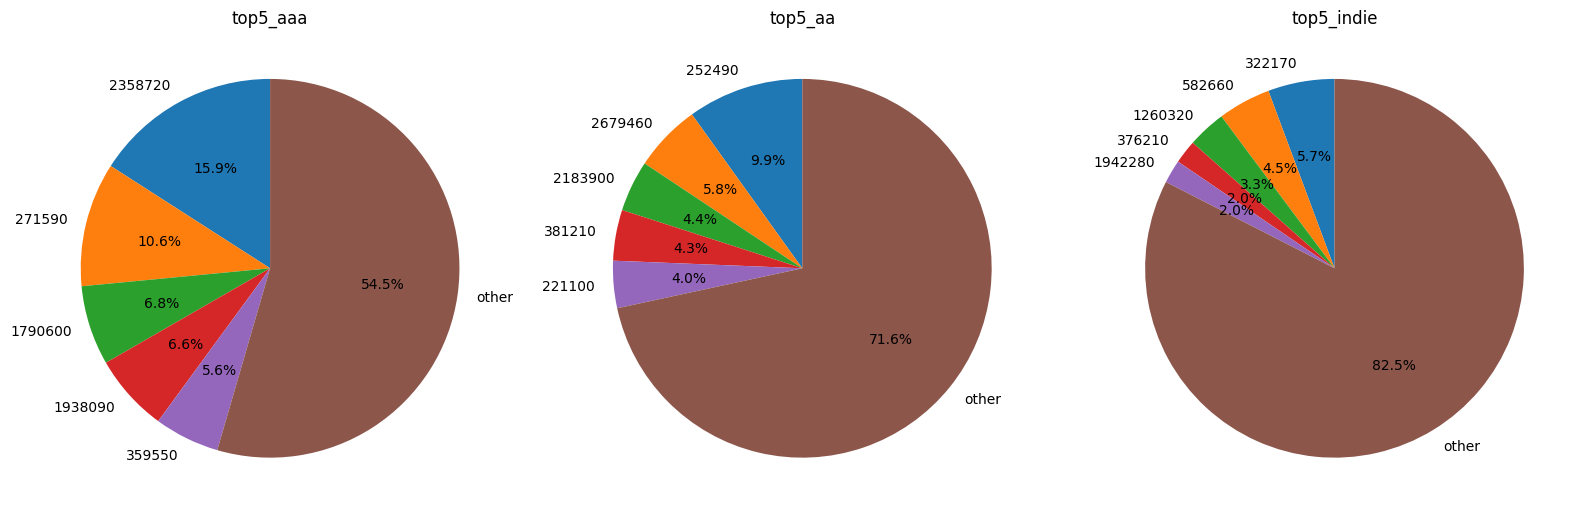

In [222]:
df_genres_list = game_top5_df_list('genres','Action')
df_name = ['top5_aaa', 'top5_aa', 'top5_indie',]
create_subpie(df_genres_list,df_name)

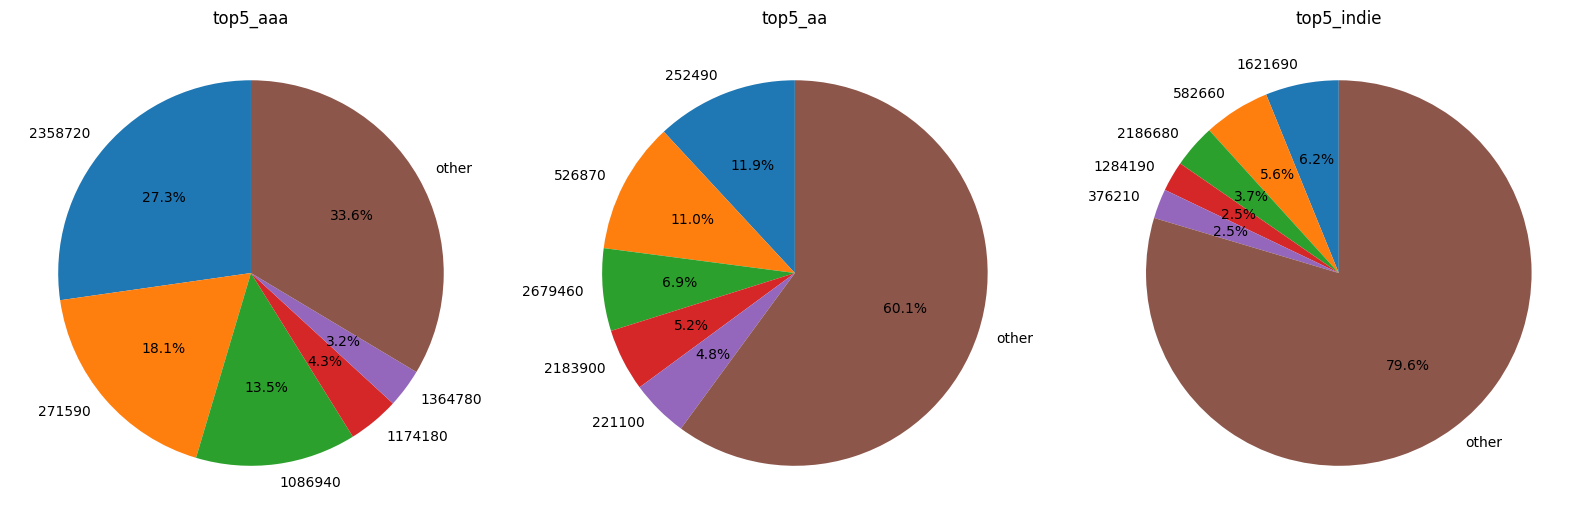

In [223]:
df_genres_list = game_top5_df_list('genres','Adventure')
df_name = ['top5_aaa', 'top5_aa', 'top5_indie',]
create_subpie(df_genres_list,df_name)